In [1]:
%load_ext autoreload
%autoreload 2
import os
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join
from tqdm import tqdm
import pandas as pd
import imodelsx.process_results
import pickle as pkl
import viz
import sys
import notebook_helper
sys.path.append('../experiments/')
results_dir = '/home/chansingh/mntv1/tree-prompt/feb21'

r = imodelsx.process_results.get_results_df(results_dir)

# fill missing args with default values from argparse
experiment_filename = '../experiments/01_fit.py'
r = imodelsx.process_results.fill_missing_args_with_default(r, experiment_filename)
r['mean_llm_calls'] = notebook_helper.add_mean_llm_calls(r)

# group using these experiment hyperparams when averaging over random seeds
group_keys = [
    k for k in imodelsx.process_results.get_main_args_list(experiment_filename)
    if not k == 'seed'
]
ravg = (
    r
    .groupby(by=group_keys)
    .mean(numeric_only=True)
    .reset_index()
)

100%|██████████| 97/97 [00:09<00:00, 10.65it/s]


In [2]:
(
    ravg
    .sort_values(by=['dataset_name', 'model_name', 'num_prompts'], ascending=True)
    .reset_index()
    [['dataset_name', 'model_name', 'num_prompts', 'prompt_source', 'accuracy_test', 'roc_auc_test']]
    .round(3)
)

,dataset_name,model_name,num_prompts,prompt_source,accuracy_test,roc_auc_test
0,imdb,manual_boosting,1,data_demonstrations,0.748,0.748
1,imdb,manual_boosting,3,manual,0.872,0.926
2,imdb,manual_ensemble,1,data_demonstrations,0.748,0.748
3,imdb,manual_ensemble,1,manual,0.872,0.872
4,imdb,manual_ensemble,5,data_demonstrations,0.854,0.915
...,...,...,...,...,...,...
92,sst2,manual_tree,5,manual,0.845,0.880
93,sst2,manual_tree,7,data_demonstrations,0.596,0.605
94,sst2,manual_tree,7,manual,0.849,0.895
95,sst2,manual_tree,10,data_demonstrations,0.592,0.628


prompt_source data_demonstrations


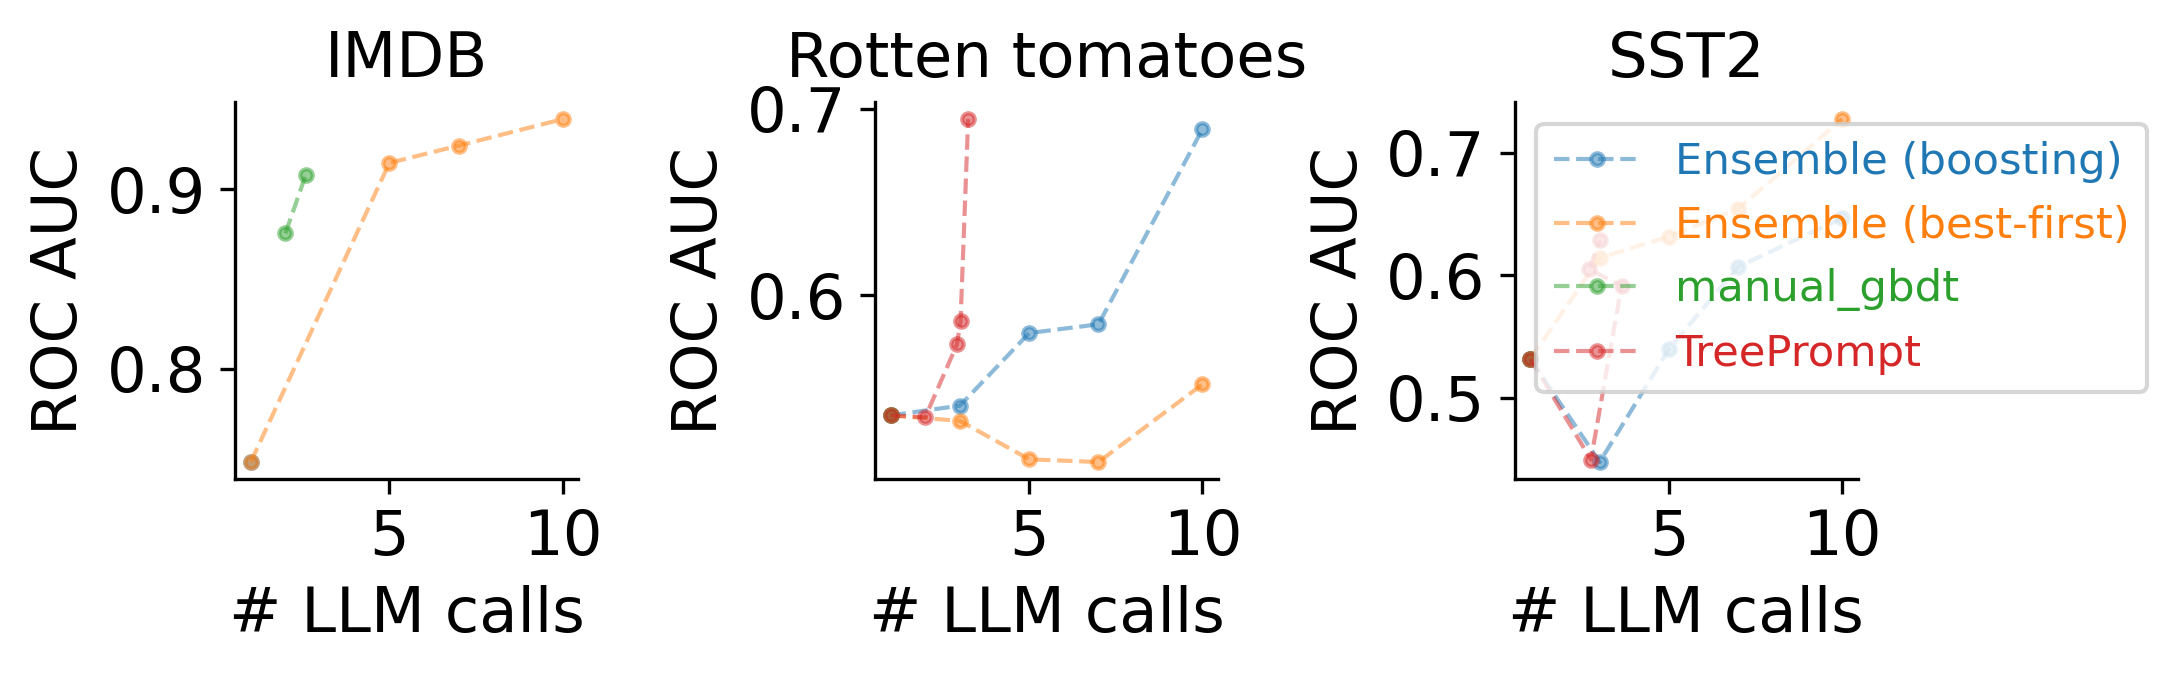

prompt_source manual


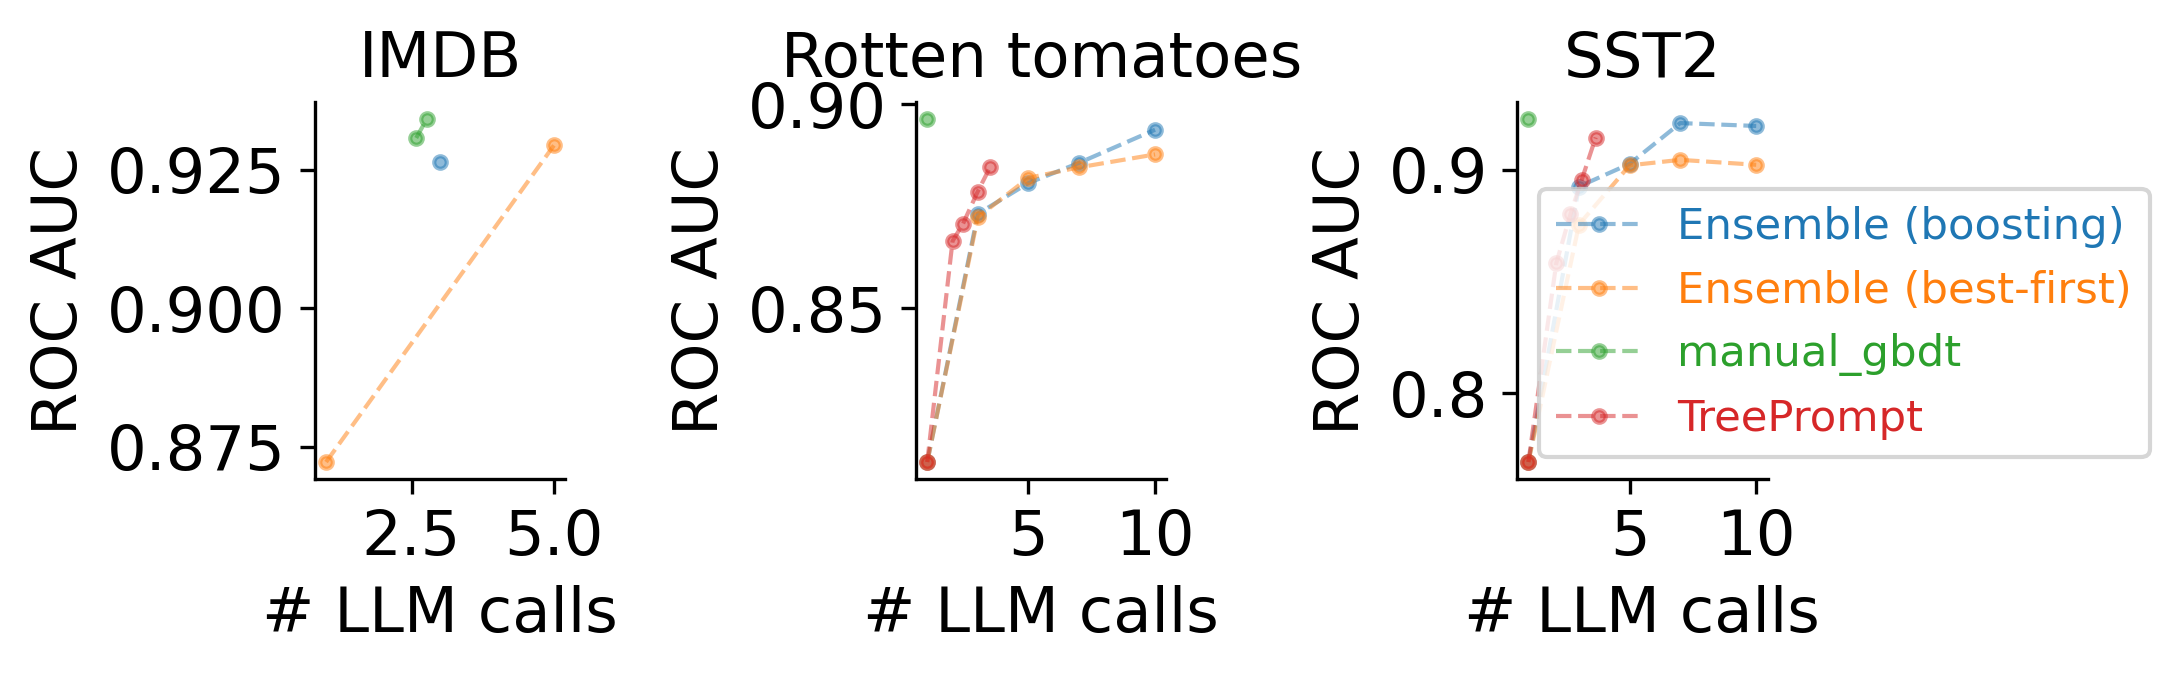

In [4]:
for prompt_source in r['prompt_source'].unique():
    print('prompt_source', prompt_source)
    rcurve = ravg[ravg.checkpoint == 'gpt2-xl']
    # rcurve = ravg[ravg.checkpoint == 'gpt2']
    rcurve = rcurve[rcurve.prompt_source == prompt_source]

    groupings = ['model_name', 'max_features', 'ngrams',
                'refinement_strategy', 'use_llm_prompt_context', 'use_stemming']
    metric = 'roc_auc'
    # metric = 'accuracy'
    x = 'mean_llm_calls'
    # x = 'num_prompts'

    viz.plot_perf_curves_individual(rcurve, x=x)
    # plt.suptitle(f'{prompt_source} prompts', fontsize='x-small')
    plt.show()

### Apply cross-validation

In [ ]:
# apply cross validation
ravg_cv = (
    ravg
    .sort_values(by='accuracy_cv', ascending=False)
    .groupby(by=['split_strategy', 'dataset_name'])
    .first()
    .reset_index()
)
ravg_cv

In [ ]:
sns.barplot(data=ravg_cv, x='model_name', y='accuracy_test') #, hue='dataset_name')
plt.show()

Load an individual model

In [ ]:
run_args = r[r.model_name == 'manual_tree'].iloc[0]
model = pkl.load(open(join(run_args.save_dir_unique, 'model.pkl'), 'rb'))
model